In [44]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parsing_utils import *
from utils.utils import *
from scripts.parse_results import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
def update_alg_name(df, cols):
    df['alg_name'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [46]:
## specify all the constants here
RES_DIR = "./all_results/plan_pg_err_new1/1a100_runs"

#COLS = ["loss_func", "cost_model", "hidden_layer_size", "weight_decay"]
COLS = ["loss_func", "cost_model", "normalize_flow_loss"]

COLORS = ["red", "black", "green", "orange", "violet", "lightblue", "cyan", "gray"]
MSE_COLOR = "blue"
# or None, for all cost models
COST_MODEL = None
MAX_EPOCH = None
HLS = None
# Add conditions

In [ ]:
# FIXME: this is really slow
all_df2 = get_all_training_df(RES_DIR)

In [ ]:
# apply all the filter conditions
all_df2.keys()
try:
    all_df2["cost_model"] = all_df2["cost_model"].apply(lambda row: COST_MODEL_NAMES[row])
except:
    pass
update_alg_name(all_df2, COLS)
if COST_MODEL is not None:
    all_df2 = all_df2[all_df2["cost_model"] == COST_MODEL]
if MAX_EPOCH is not None:
    all_df2 = all_df2[all_df2["epoch"] <= max_epoch]
if HLS is not None:
    all_df2 = all_df2[all_df2["hidden_layer_size"] == HLS]
    
HUE_COLORS = {}
algs = list(set(all_df2["alg_name"]))
algs.sort()
for i,alg in enumerate(algs):
    #HUE_COLORS[alg] = COLORS[i]
    if "mse" in alg:
        HUE_COLORS[alg] = MSE_COLOR
    else:
        HUE_COLORS[alg] = COLORS[i]
        
print(HUE_COLORS)

In [ ]:
# divides into df, and template specific df
df = all_df2[all_df2["template"] == "all"]
df = df[df["num_tables"] == "all"]
df = df[df["summary_type"] == "mean"]
df = df[df["weight_decay"] != 1.0]
all_df = all_df2[all_df2["template"] != "all"]
all_df = all_df[all_df["summary_type"] == "mean"]
#df = df[df["lr"] == 0.0001]

In [ ]:
pd.set_option('display.max_rows', 500)
#pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
#tmp_df = tmp_df.round(2)
tmp_df = all_df[~all_df["loss_type"].str.contains("gradient")]
sort_df = tmp_df[tmp_df["loss_type"] == "mm1_plan_err"]
sgb = sort_df.groupby("template").mean()
template_order = sgb.sort_values(by=["loss"])["loss"]
print(template_order)
print(template_order.index)

gb = tmp_df.groupby(["template", "loss_type"]).mean()
# TODO: figure out how to reindex this
#print(gb["loss"])

In [ ]:
set(df["feat_tolerance"])

# Models

## Naming Convention: loss_costmodel_normalize-flow-loss

## Green: Flow Loss + Separate Edges for min(...), w/o flow loss normalization
## Red: Flow Loss, w/o flow loss normalization
## Black: Flow Loss, w/ flow loss normalization

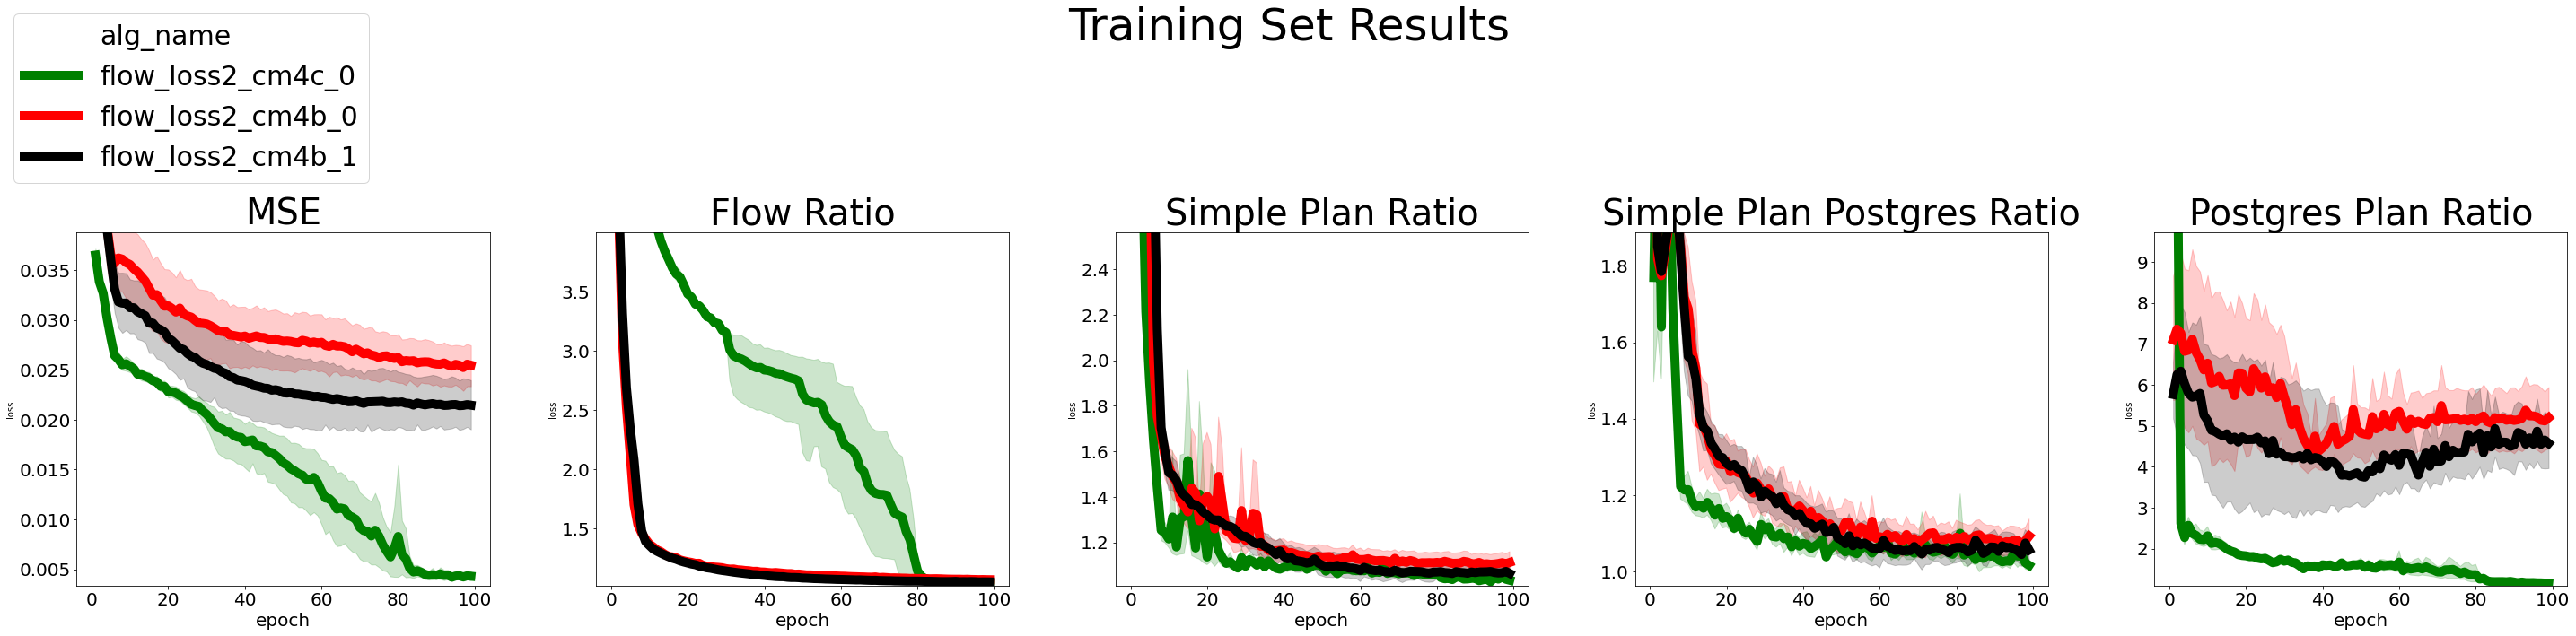

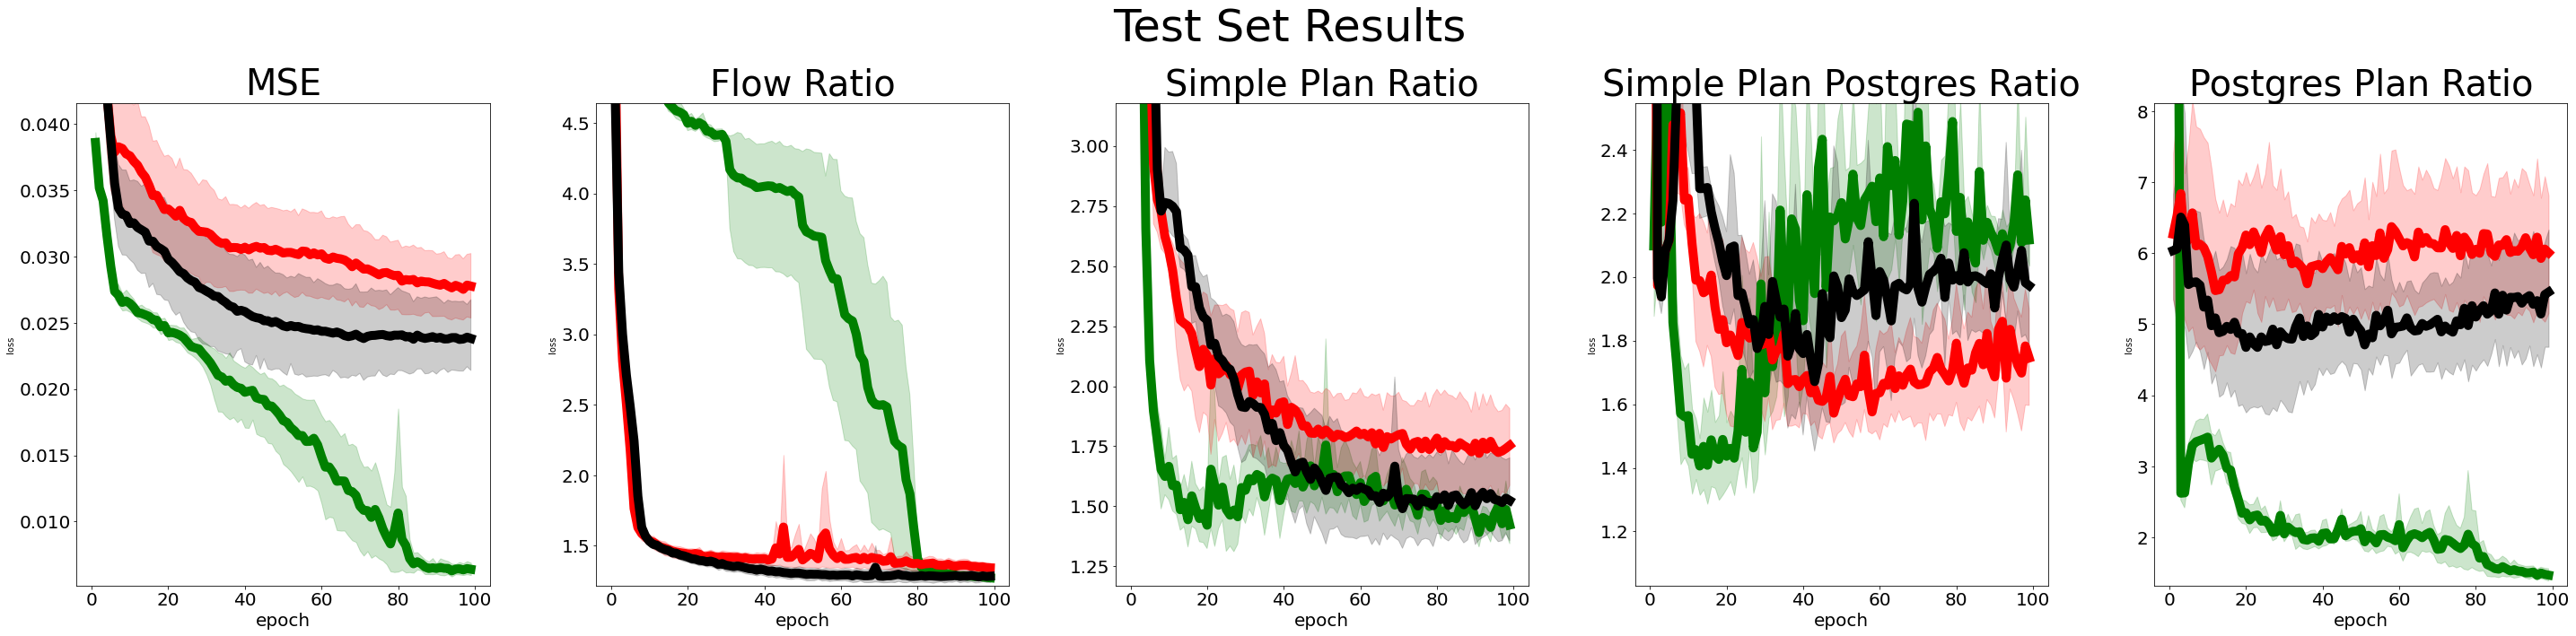

In [47]:
construct_summary(df, "train", "Training Set Results", "ratio", HUE_COLORS=HUE_COLORS)
construct_summary(df, "test", "Test Set Results", "ratio", HUE_COLORS=HUE_COLORS)

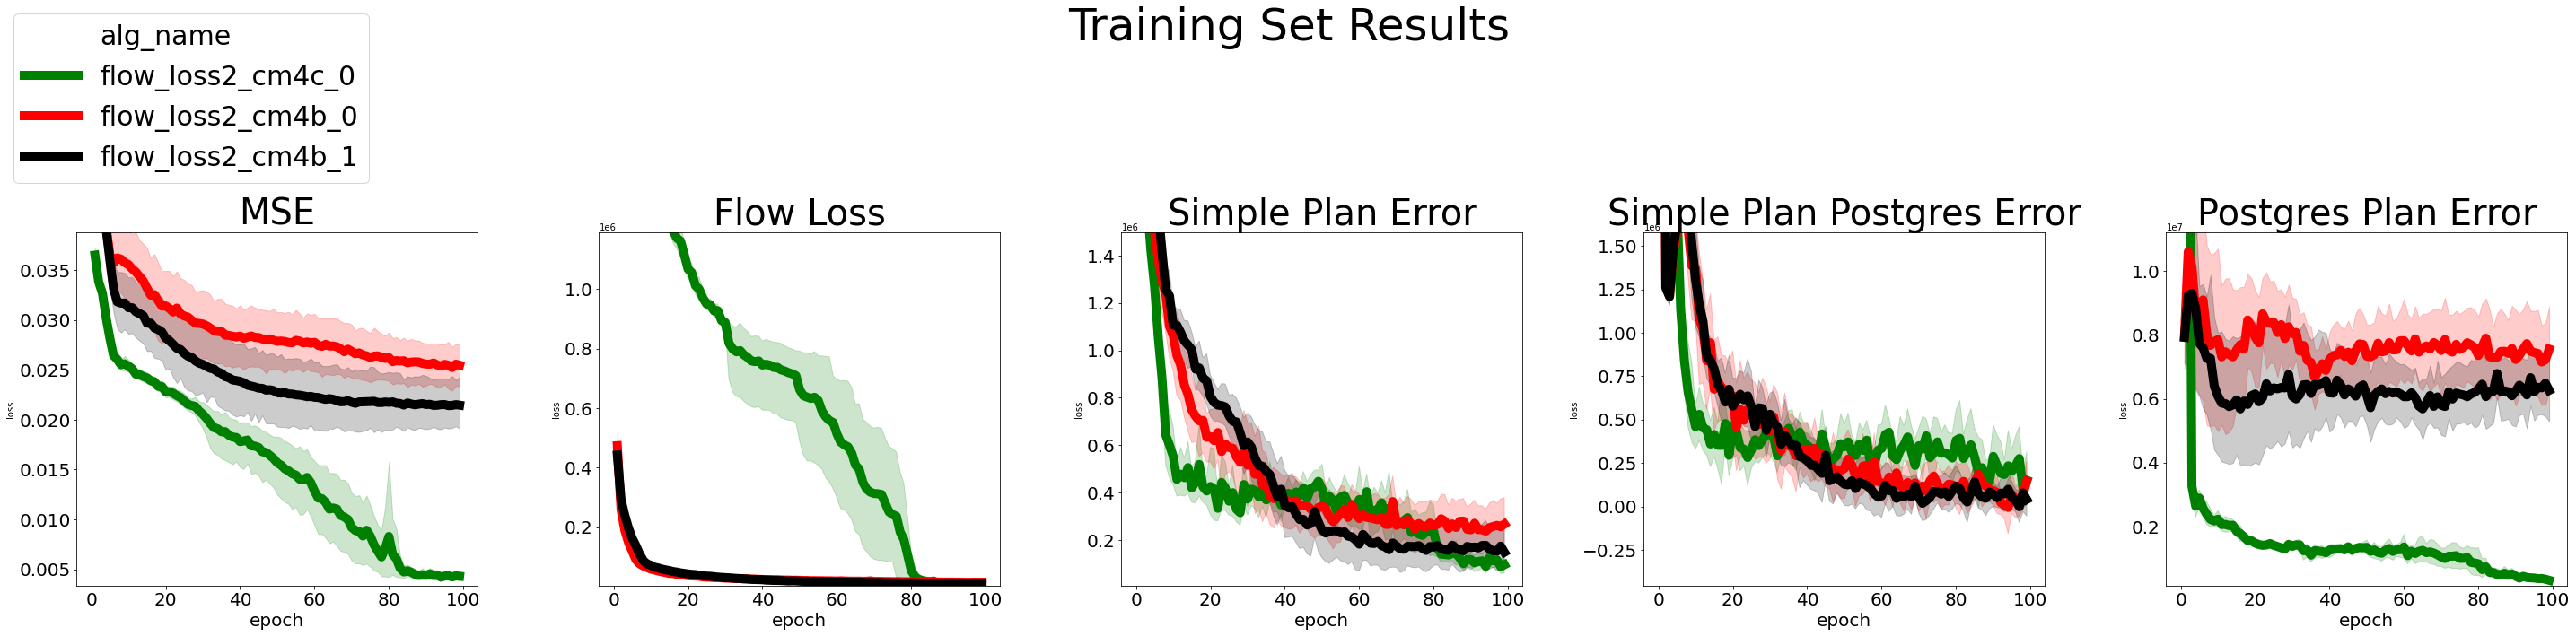

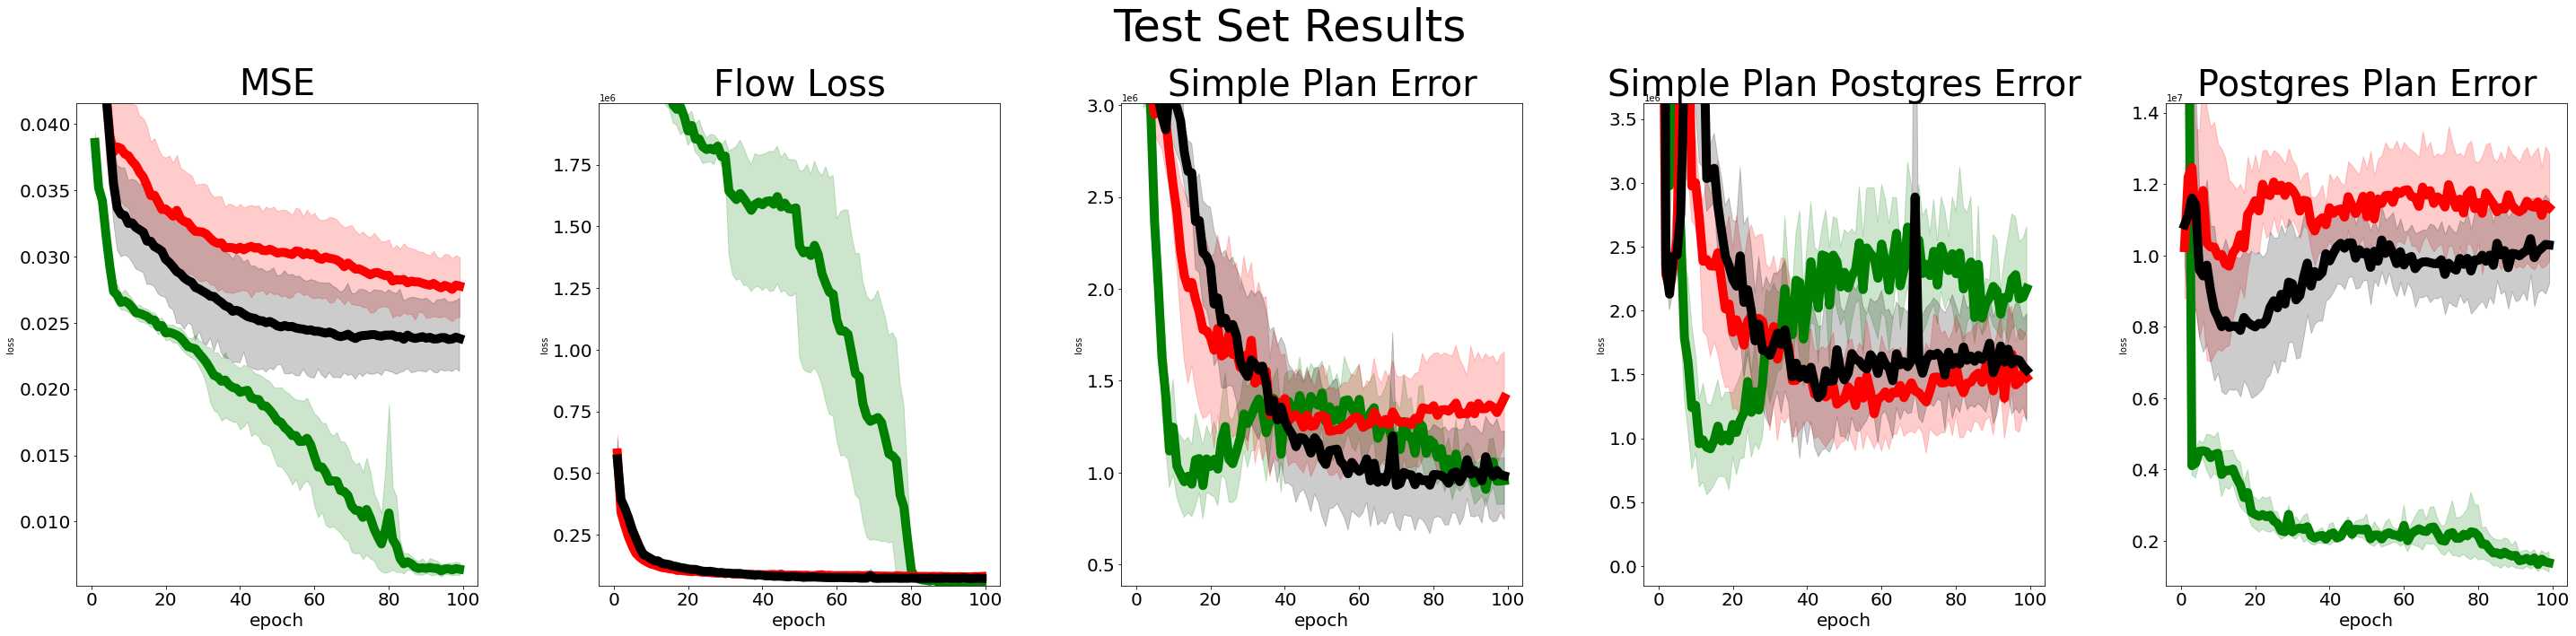

In [48]:
construct_summary(df, "train", "Training Set Results", "err", HUE_COLORS=HUE_COLORS)
construct_summary(df, "test", "Test Set Results", "err", HUE_COLORS=HUE_COLORS)

In [ ]:
templates = list(set(all_df["template"]))
templates.sort()
for temp in templates:
    tmp_df = all_df[all_df["template"] == temp]
    tmp_df = tmp_df[tmp_df["num_tables"] == "all"]
    construct_summary(tmp_df, "train", temp + " :Training Set Results", "ratio", HUE_COLORS=HUE_COLORS)
    construct_summary(tmp_df, "train", temp + " :Training Set Results", "err", HUE_COLORS=HUE_COLORS)
    
    construct_summary(tmp_df, "test", temp + " :Test Set Results", "ratio", HUE_COLORS=HUE_COLORS)
    construct_summary(tmp_df, "test", temp + " :Test Set Results", "err", HUE_COLORS=HUE_COLORS)
    
    

# Gradients wrt Model Parameters (per layer)

* Each column represents a different "layer", 10 layers because:
    * 4 independent fully connected NN, with 1 hidden layer for Table Features, Join Features, Predicate Features, and Flow Features
    * 2 final layers which combines the output of the ones before
* mean (abs (gradient_vec)) where greadient_vec is calculated per query at each update step
* Plotted separately for models because scales somewhat different (not sure...why?!)

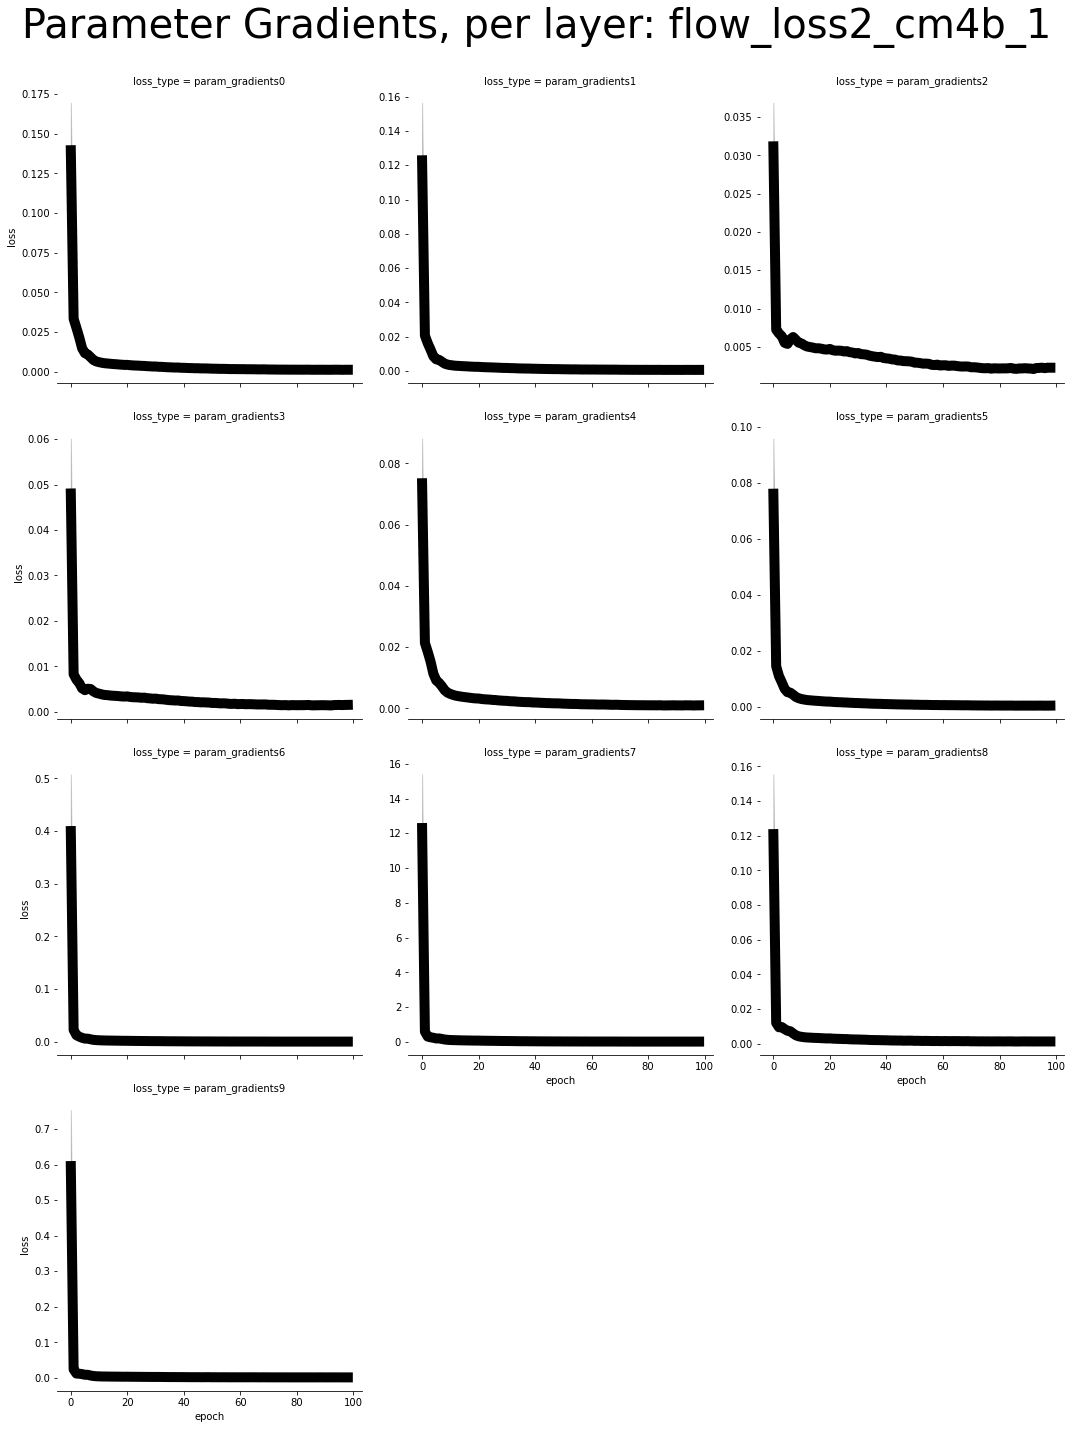

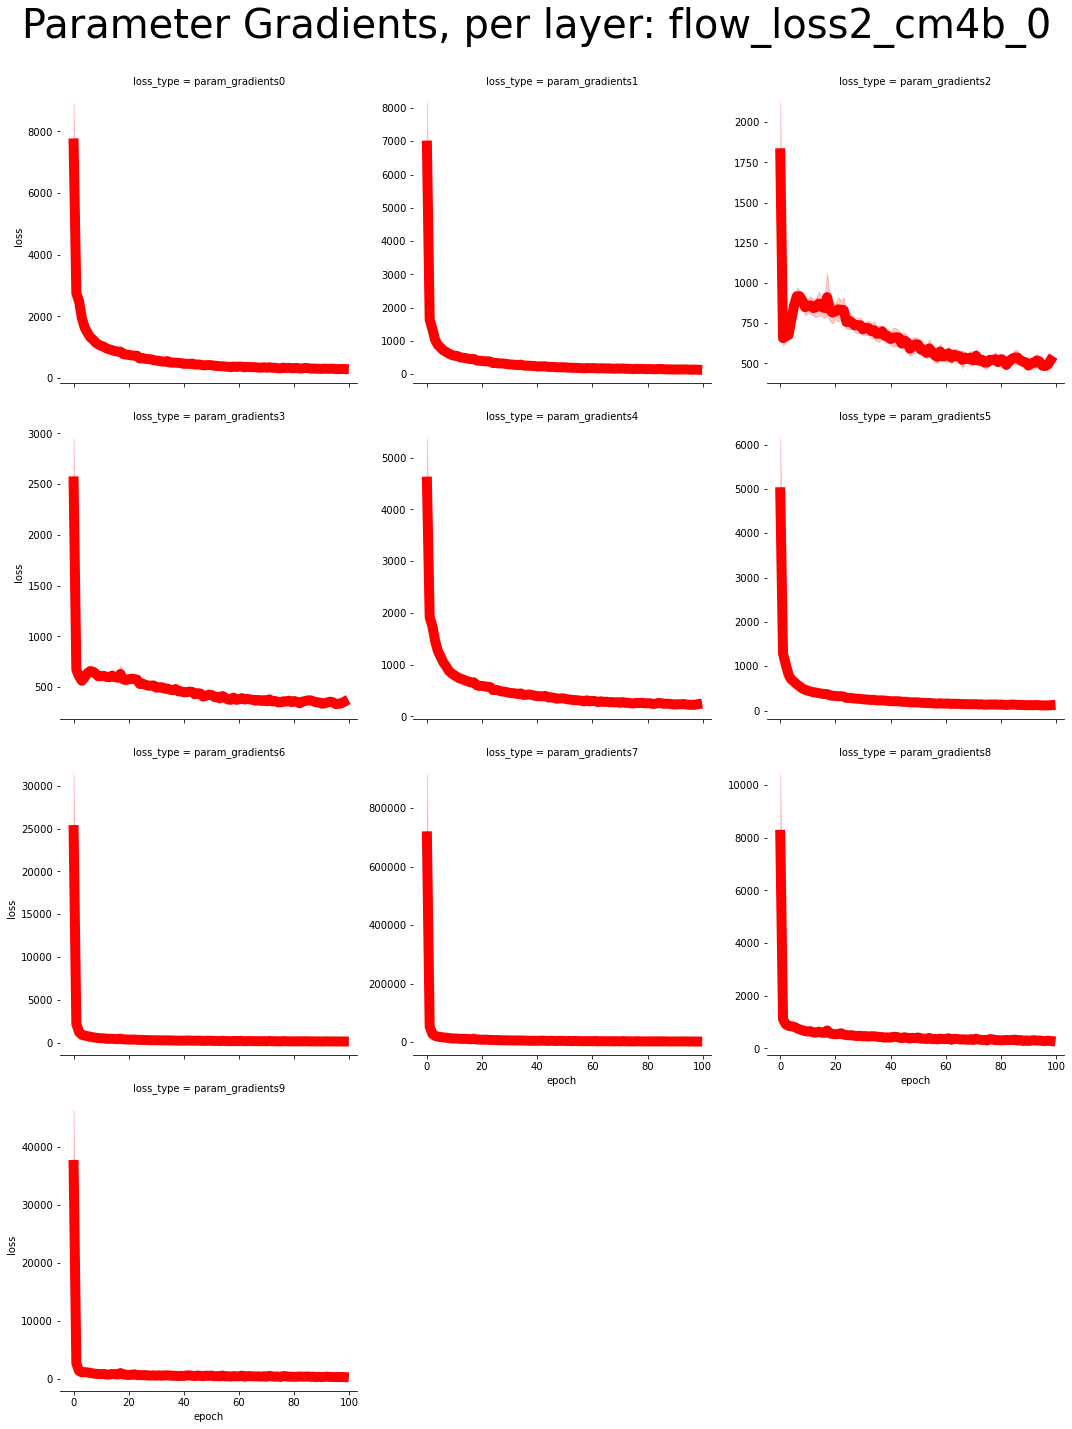

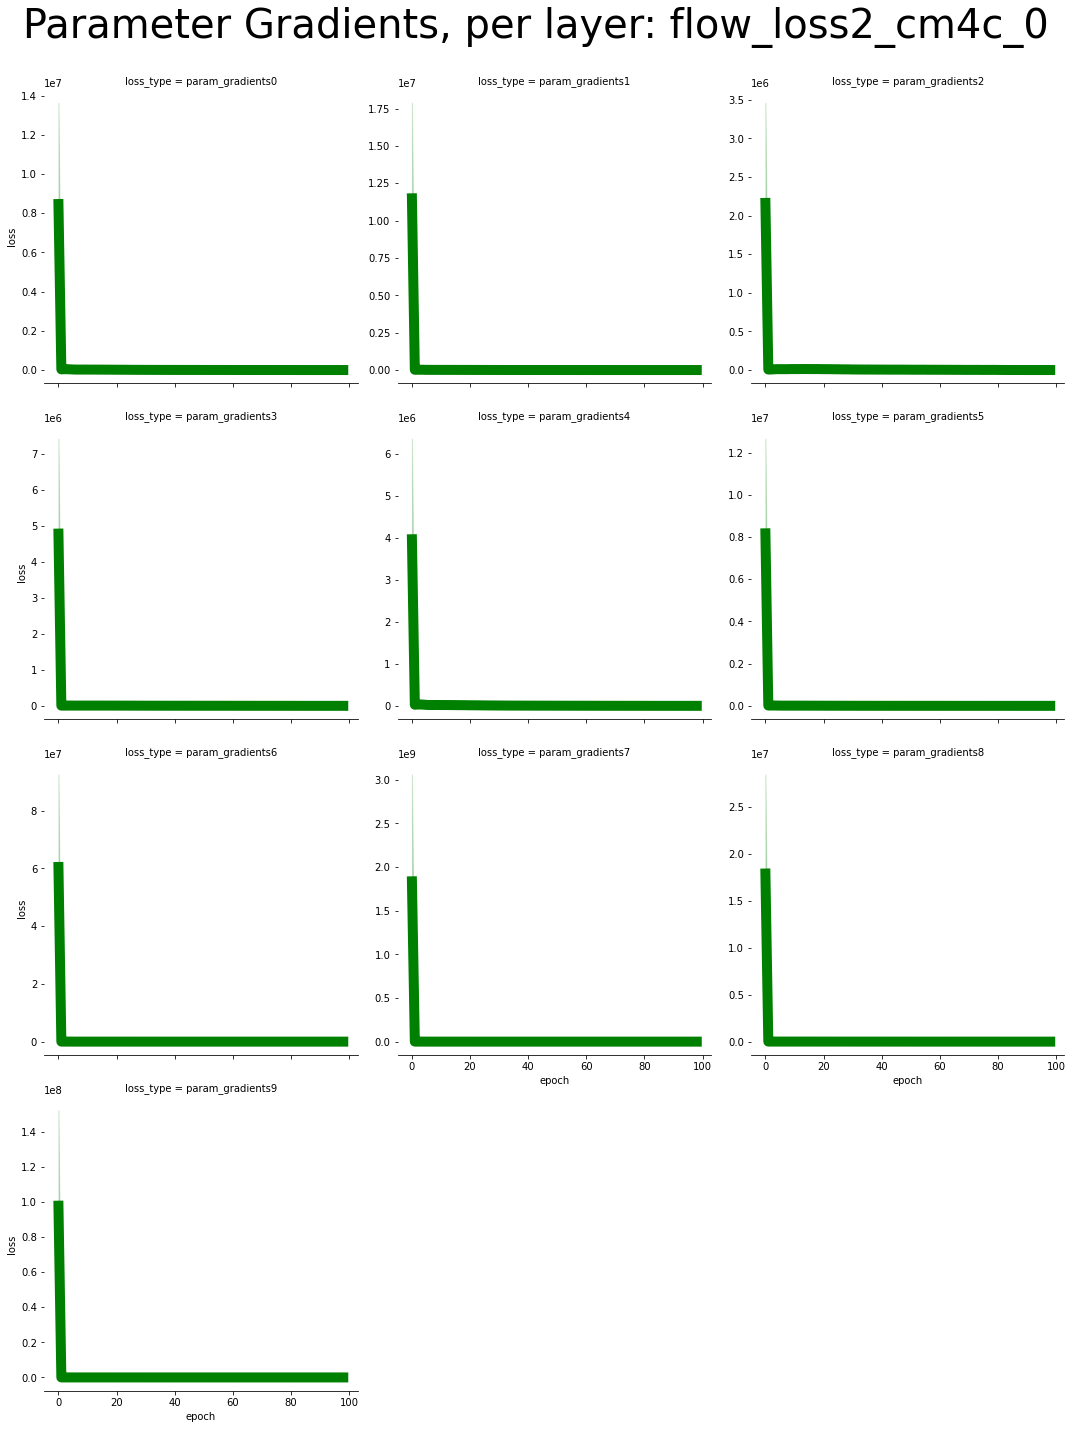

In [49]:
param_gradients =  [g for g in set(df["loss_type"]) if "param" in g]
param_gradients.sort()
par_grad_df = df[df["loss_type"].isin(param_gradients)]
algs = set(par_grad_df["alg_name"])
for alg in algs:
    plot_alg_grad(par_grad_df, alg, HUE_COLORS=HUE_COLORS)

# Gradients wrt Model Parameters (per template)

* Each column represents a different template. (so averaging across all layers)
* mean (abs (gradient_vec)) where greadient_vec is calculated per query at each update step

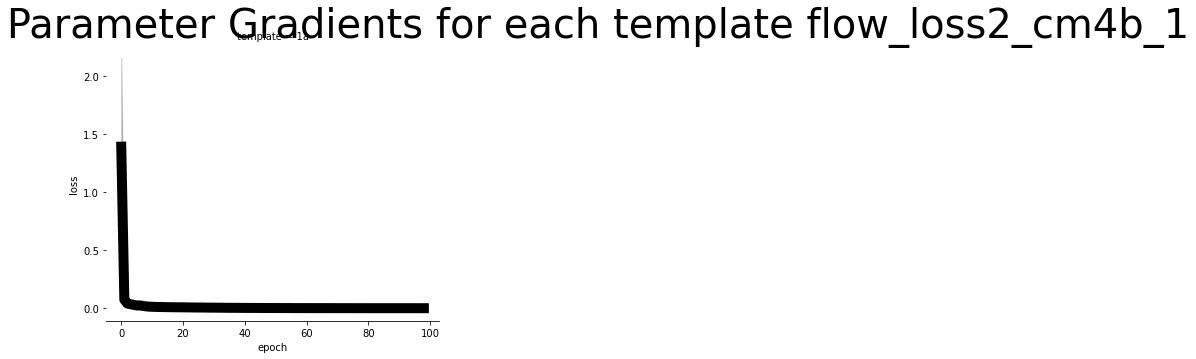

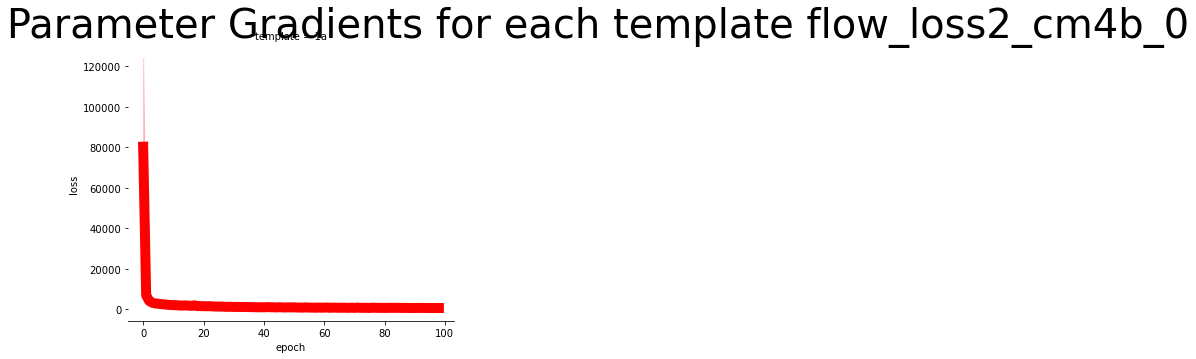

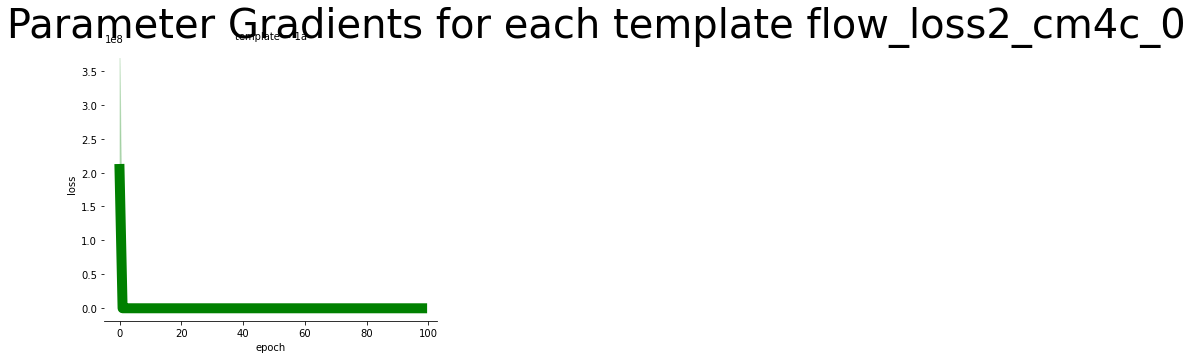

In [50]:
param_gradients =  [g for g in set(df["loss_type"]) if "param" in g]
param_gradients.sort()
par_grad_df = all_df[all_df["loss_type"].isin(param_gradients)]
algs = set(par_grad_df["alg_name"])
for alg in algs:
    plot_tmp_grad(par_grad_df, alg, HUE_COLORS=HUE_COLORS)

# Gradients wrt Model Output

* mean (abs (gradient_vec)) where greadient_vec is calculated per query at each update step

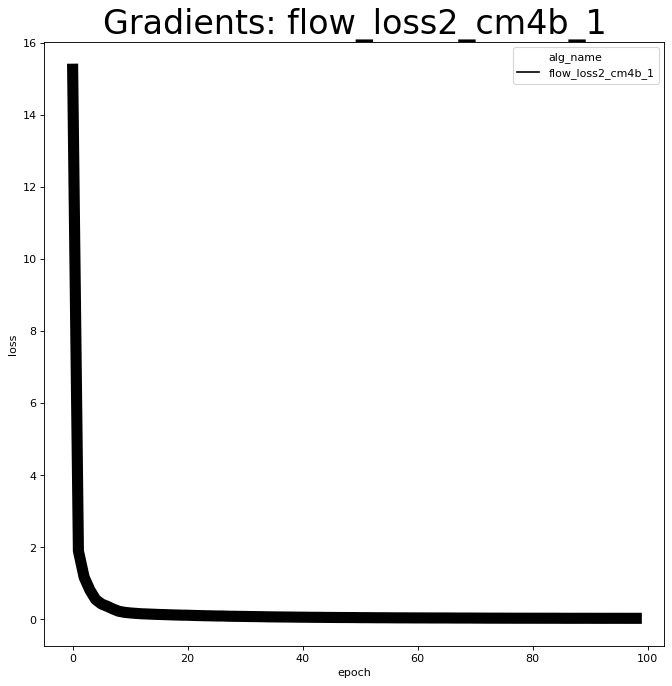

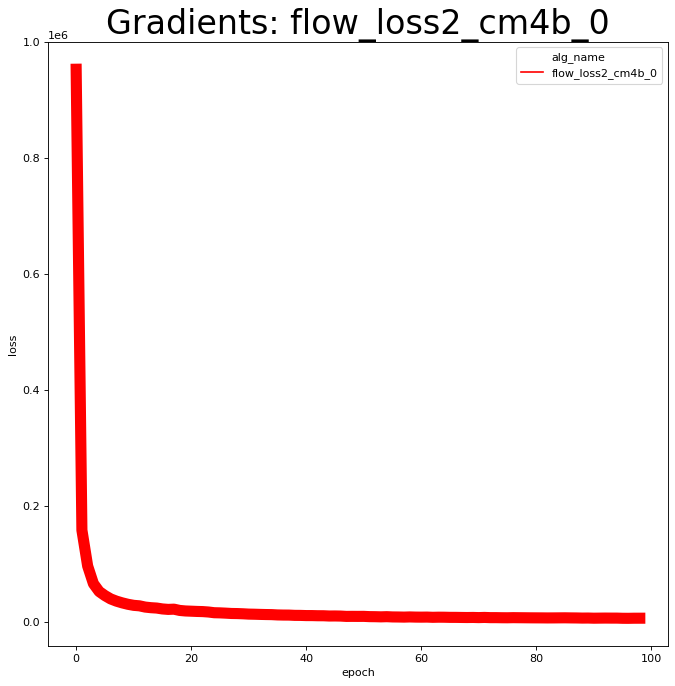

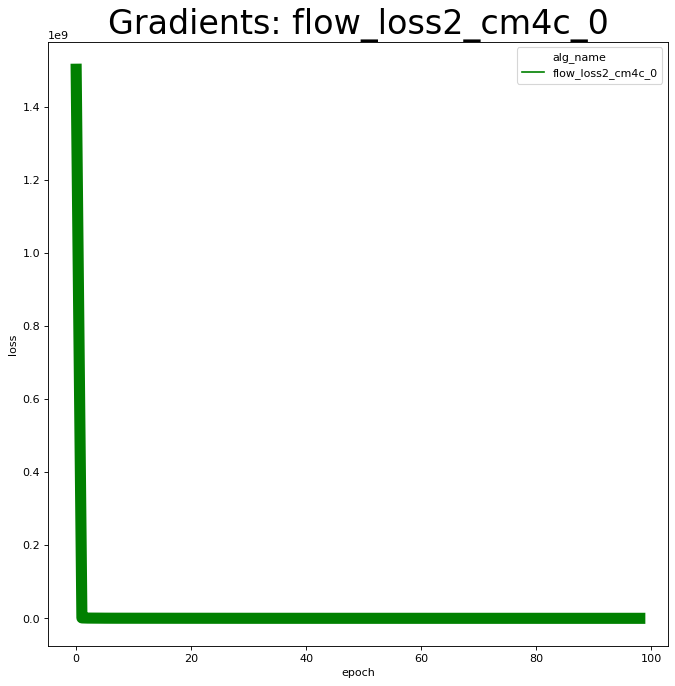

In [51]:
def plot_grad(df, alg_name, ylim):
    fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    cur_df = df[df["alg_name"] == alg_name]
    #cur_df = cur_df[cur_df["lr"] == lr]
    sns.lineplot(x="epoch", y="loss", data=cur_df, hue="alg_name", palette=HUE_COLORS, ci=None, 
                 linewidth=10.0)
    plt.ylim(ylim)
    alg_name = list(set(cur_df["alg_name"]))[0]
    plt.title("Gradients: " + alg_name, fontsize=30)
    #plt.yscale("log")
    plt.show()
    #plt.clf()

# Gradients
grad_df = df[df["loss_type"] == "gradients"]
algs = set(grad_df["alg_name"])
for alg in algs:
    plot_grad(grad_df, alg, (None, None))

# Loss Results

## Train - Test results over all the losses, and 6000+ queries each in the training / test sets

In [ ]:
plot_loss_template(all_df, "qerr", "train", "log", HUE_COLORS)
plot_loss_template(all_df, "qerr", "test", "log", HUE_COLORS)

# Flow Error

## Flow_Loss - Optimal_Flow_loss

In [ ]:
plot_loss_template(all_df, "flow_err", "train", "linear", HUE_COLORS)
plot_loss_template(all_df, "flow_err", "test", "linear", HUE_COLORS)

# Flow Ratio

## Flow_Loss / Optimal_Flow_loss

In [ ]:
plot_loss_template(all_df, "flow_ratio", "train", "linear", HUE_COLORS)
plot_loss_template(all_df, "flow_ratio", "test", "linear", HUE_COLORS)

# MM1 Cost Model: Plan Error

## Simple Cost model that we used to define flow loss

## Plan Cost  - Optimal Plan Cost

In [ ]:
plot_loss_template(all_df, "mm1_plan_err", "train", "linear", HUE_COLORS)
plot_loss_template(all_df, "mm1_plan_err", "test", "linear", HUE_COLORS)

# MM1 Cost Model: Plan Ratio

## Simple Cost model that we used to define flow loss

## Plan Cost  / Optimal Plan Cost

In [ ]:
plot_loss_template(all_df, "mm1_plan_ratio", "train", "linear", HUE_COLORS)
plot_loss_template(all_df, "mm1_plan_ratio", "test", "linear", HUE_COLORS)

# Postgres Cost Model based errors

# Simple Cost Model Plan, Postgres Error

In [ ]:
plot_loss_template(all_df, "mm1_plan_pg_err", "train", "linear", HUE_COLORS)
plot_loss_template(all_df, "mm1_plan_pg_err", "test", "linear", HUE_COLORS)

In [ ]:
plot_loss_template(all_df, "mm1_plan_pg_ratio", "train", "linear", HUE_COLORS)
plot_loss_template(all_df, "mm1_plan_pg_ratio", "test", "linear", HUE_COLORS)

# Postgres Cost Model for both Plan and Errors

In [ ]:
plot_loss_template(all_df, "jerr", "train", "linear", HUE_COLORS)
plot_loss_template(all_df, "jerr", "test", "linear", HUE_COLORS)

In [ ]:
plot_loss_template(all_df, "jerr_ratio", "train", "linear", HUE_COLORS)
plot_loss_template(all_df, "jerr_ratio", "test", "linear", HUE_COLORS)